In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.neighbors import DistanceMetric
from pandas.plotting import lag_plot
from sklearn.cluster import DBSCAN

data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

In [2]:
data = main.getdata('data/timeseries25May.csv')

In [3]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [4]:
len(data['country'].unique())

10

Check for missing data

In [5]:
datelist = [date for date in pd.date_range(start='2019-12-31', end='2020-05-25') if len(data.loc[data['date'] == date]) != 10]

In [6]:
missing = [[(country, date.ctime()) for country in ['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'] if country not in list(data.loc[data['date'] == date]['country'].values)] for date in datelist]

In [7]:
missing

[[('Romania', 'Tue Mar  3 00:00:00 2020')],
 [('Romania', 'Thu Mar  5 00:00:00 2020')],
 [('Spain', 'Mon May 25 00:00:00 2020')]]

Check for negative values

In [8]:
negative = data.loc[data['cases'] < 0]
negative

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
16493,2020-04-19,19,4,2020,-713,410,Spain,ES,ESP,46723749.0,Europe
18258,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991.0,Europe


In [9]:
data = data.drop(negative.index.values)

In [10]:
data.loc[data['cases'] < 0]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp


Show autocorrelation

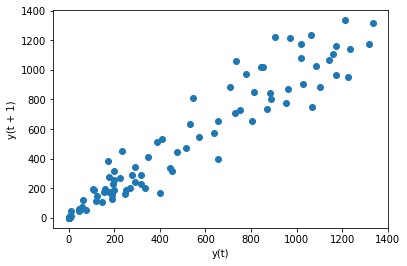

In [11]:
lag_plot(data.loc[data['country']=='Netherlands', 'cases'])
plt.show()

Add columns for cases of yesterday and predictions of yesterday. 

In [12]:
data = data.assign(expcasesyest=np.nan, casesyest=np.nan)

In [13]:
for country in data['country'].unique(): 
    data.loc[data['country']==country, 'casesyest'] = data.loc[data['country']==country].cases.shift(1)

In [14]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesyest,casesyest
18400,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe,NaN,NaN
4966,2019-12-31,31,12,2019,0,0,Denmark,DK,DNK,5797446.0,Europe,NaN,NaN
6990,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe,NaN,NaN
9337,2019-12-31,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe,NaN,NaN
1979,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe,NaN,NaN


Separate countries, make sure first record is equal to the first case date, reindex dataframes and set the first expcasesyest to 0. 

In [15]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)
    country[0].loc[0,'expcasesyest']=0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
dataframes, _ = zip(*countries)

In [17]:
dataframes[0].head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesyest,casesyest
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe,NaN,1.0
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe,NaN,1.0
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe,NaN,5.0
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe,NaN,6.0


Euclidean distance between timeseries

In [18]:
distance = {}
for i in range(len(dataframes)-1): 
    j = i+1
    while j <= (len(dataframes)-1): 
        if len(dataframes[i]['cases'].values) < len(dataframes[j]['cases'].values): 
            length = len(dataframes[i]['cases'].values)
        else: 
            length = len(dataframes[j]['cases'].values)
        distance[(dataframes[i]['country'].values[0], dataframes[j]['country'].values[0])] = np.sqrt(np.sum(np.square(dataframes[i]['cases'].values[:length]-dataframes[j]['cases'].values[:length])))
        j +=1

In [19]:
distance

{('Netherlands', 'Norway'): 5153.704492886646,
 ('Netherlands', 'Belgium'): 2934.3779579324814,
 ('Netherlands', 'Germany'): 20923.07919499422,
 ('Netherlands', 'Denmark'): 4858.090983092021,
 ('Netherlands', 'Sweden'): 3876.9958730955595,
 ('Netherlands', 'Romania'): 4142.477640253475,
 ('Netherlands', 'Italy'): 23427.981325756602,
 ('Netherlands', 'United_Kingdom'): 29169.202663082855,
 ('Netherlands', 'Spain'): 29196.70043001435,
 ('Norway', 'Belgium'): 7040.231246202074,
 ('Norway', 'Germany'): 25100.044422271447,
 ('Norway', 'Denmark'): 931.074647920348,
 ('Norway', 'Sweden'): 3418.757669095603,
 ('Norway', 'Romania'): 1724.6443111552016,
 ('Norway', 'Italy'): 28196.109465669197,
 ('Norway', 'United_Kingdom'): 31720.21111216002,
 ('Norway', 'Spain'): 33747.33642822793,
 ('Belgium', 'Germany'): 19351.26135423735,
 ('Belgium', 'Denmark'): 6724.421164680273,
 ('Belgium', 'Sweden'): 5638.893419812082,
 ('Belgium', 'Romania'): 6042.453888942803,
 ('Belgium', 'Italy'): 21993.95982991694

create distance matrix + use DBSCAN for clustering countries

In [20]:
distmat = np.zeros((10, 10))
for i in range(len(dataframes)-1): 
    j = 0
    while j <= (len(dataframes)-1): 
        if len(dataframes[i]['cases'].values) < len(dataframes[j]['cases'].values): 
            length = len(dataframes[i]['cases'].values)
        else: 
            length = len(dataframes[j]['cases'].values)
        distmat[i][j] = np.sqrt(np.sum(np.square(dataframes[i]['cases'].values[:length]-dataframes[j]['cases'].values[:length])))
        j +=1

In [21]:
clustering = DBSCAN(eps=np.median(distmat), min_samples=2).fit(distmat)
clustering.labels_

array([ 0,  0,  0, -1,  0,  0,  0, -1, -1, -1])

In [22]:
for country, label in zip(['Netherlands', 'Norway', 'Belgium', 'Germany', 'Denmark', 'Sweden', 'Romania', 'Italy', 'United_Kingdom', 'Spain'], clustering.labels_):
    print(country, ":", label)

Netherlands : 0
Norway : 0
Belgium : 0
Germany : -1
Denmark : 0
Sweden : 0
Romania : 0
Italy : -1
United_Kingdom : -1
Spain : -1


Regression model based on https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958 and http://economiaweb.unipv.it/wp-content/uploads/2018/01/DEMWP0185.pdf. 

In [23]:
expr = """cases ~  (np.log(1+casesyest)) + (np.log(1+expcasesyest))"""
finalSummaries = []
paramsAll = []
for country in dataframes: 
    params = []
    for i in range(1, len(country)+1):
        
        mask = np.full(len(country), False)
        if i > 0: 
            mask[(i-1):i] = True
        else: 
            mask[0] = True
        y_train, X_train = dmatrices(expr, country[mask], return_type='dataframe')

        poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

        poisson_predictions = poisson_training_results.get_prediction(X_train)
        predictions_summary_frame = poisson_predictions.summary_frame()
        if (i < len(country)): 
            country.loc[i,'expcasesyest']=int(predictions_summary_frame['mean'].values[0])
        country.loc[i-1,'expcasestoday']=int(predictions_summary_frame['mean'].values[0])

        params.append([poisson_training_results.params[0], poisson_training_results.params[1], poisson_training_results.params[2]])
    
    paramsAll.append(params)
    finalSummaries.append([country.loc[0,['country']].values[0], poisson_training_results.summary()])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self

In [78]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                    1
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.0081
Date:                Mon, 25 May 2020   Deviance:                  -1.0658e-13
Time:                        14:20:26   Pearson chi2:                 1.72e-27
No. Iterations:                     1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Plot parameter values over time

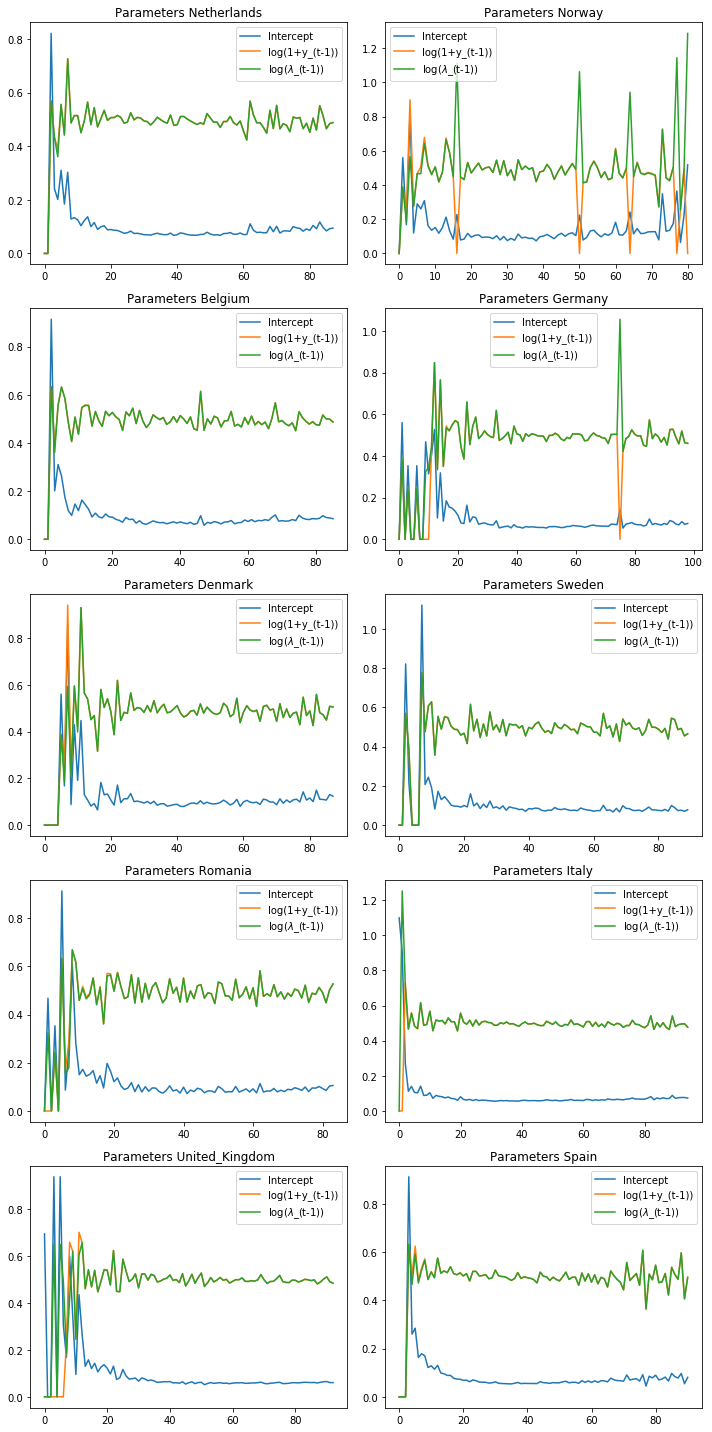

In [79]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, parameters, country in zip(axes.ravel(), paramsAll, dataframes):
    ax.plot(parameters)
    ax.set_title('Parameters '+country.loc[0,['country']].values[0])
    ax.legend(['Intercept', 'log(1+y_(t-1))', 'log($\lambda$_(t-1))'])
#     ax.set_xlabel('Day')
#     ax.set_ylabel('Cases')
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

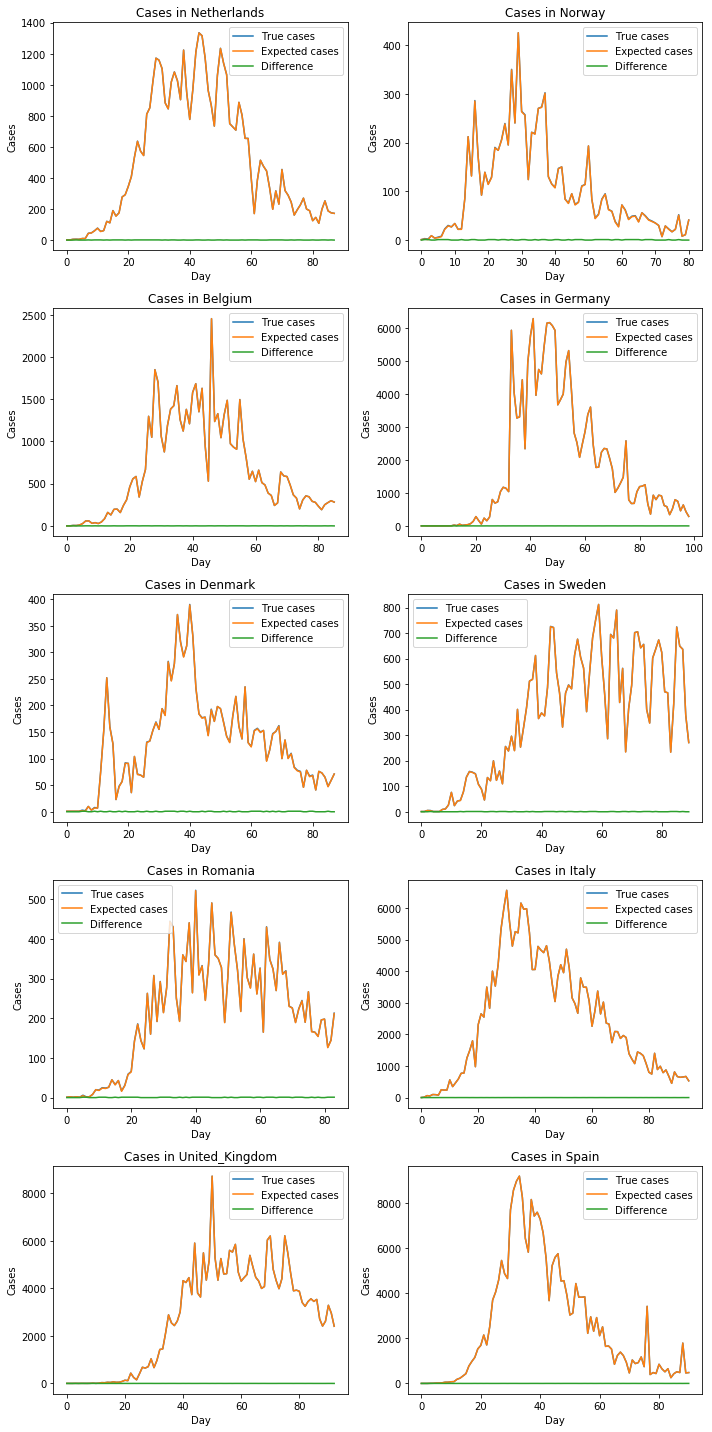

In [80]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):

    ax.plot(country[['cases']].values)
    ax.plot(country[['expcasestoday']].values)
    ax.plot(country[['cases']].values-country[['expcasestoday']].values)
#     country.plot(y=['cases', 'expcasestoday'], ax=ax, legend=False)
#     country.plot(x='date', y='expcasestoday', ax=ax, legend=False)
#     country[['cases', 'expcasestoday']].plot()

#     ax = country.plot(y="cases")
#     country.plot(y="expcasestoday", ax=ax)

#     country.plot(x='date', y='cases')
    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True cases', 'Expected cases', 'Difference'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

In [38]:
paramest = []
for parameters in paramsAll[0:5]: 
    paramest.append(np.median(parameters[30:], axis = 0))

In [39]:
coefficients = np.median(paramest, axis = 0)

In [40]:
coefficients

array([0.07603931, 0.48825983, 0.48820077])

In [41]:
for country in dataframes: 
    country.loc[0,'expcasesyestGLOBAL']=0

In [42]:
for country in dataframes: 
    for i in range(0, len(country)):
        y = coefficients[0] + coefficients[1]*(np.log(1+ country.loc[i]['casesyest'])) + coefficients[2]*(np.log(1+ country.loc[i]['expcasesyestGLOBAL']))
        if (i < len(country)):
            country.loc[i+1,'expcasesyestGLOBAL']=np.exp(y)
        country.loc[i,'expcasestodayGLOBAL']=np.exp(y)

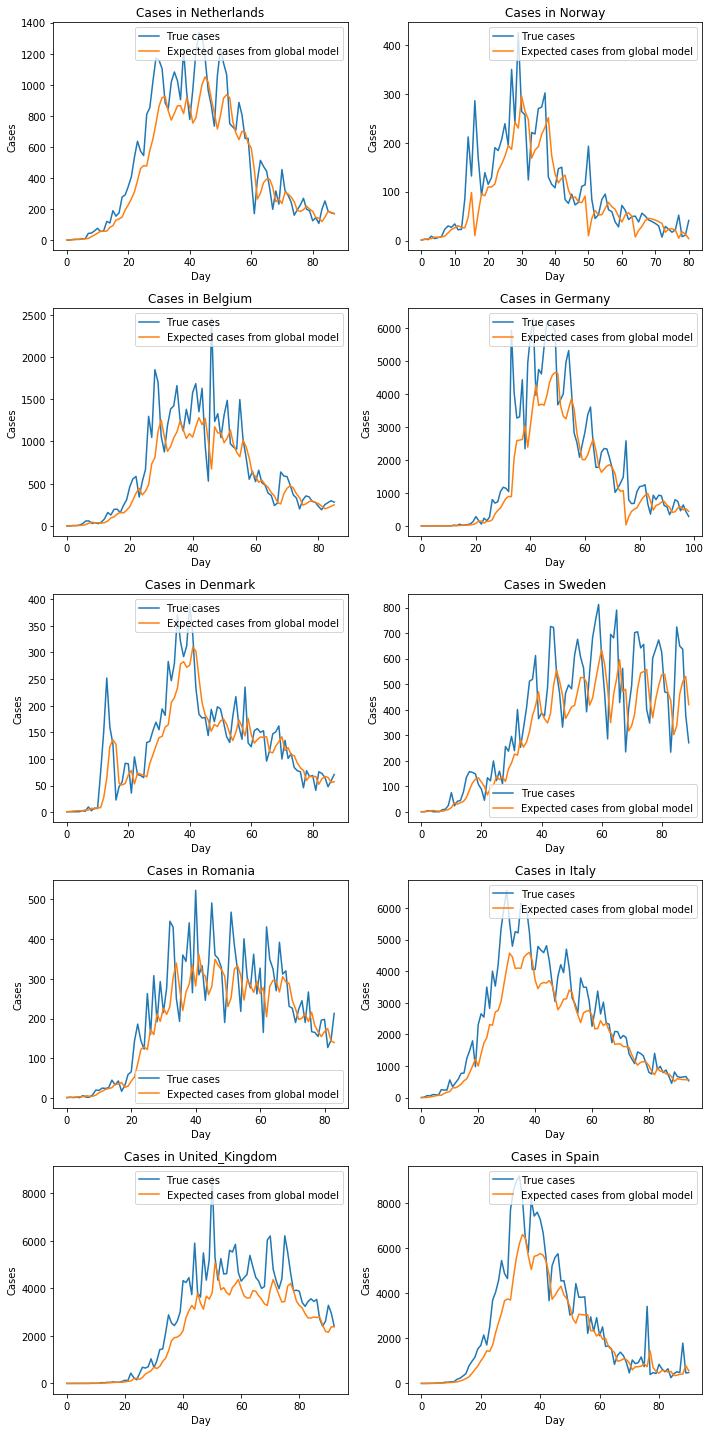

In [43]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):
    ax.plot(country[['cases']].values)
    ax.plot(country[['expcasestodayGLOBAL']].values)
#     ax.plot(country[['cases']].values-country[['expcasestodayGLOBAL']].values)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True cases', 'Expected cases from global model', 'Difference'])

fig.tight_layout()